In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import arviz as az
import pymc as pm
import seaborn as sns

from REStats.utils import load_SCADA
from cmdstanpy import install_cmdstan, CmdStanModel

In [2]:
install_cmdstan(verbose=True)

Installing CmdStan version: 2.31.0
Install directory: /home/cam/.cmdstan
CmdStan version 2.31.0 already installed


True

In [3]:
# cmap = mpl.colormaps['tab10']
sns.set_theme()

In [4]:
curr_dir = os.getcwd()

In [5]:
wt = load_SCADA(2020)

## Bayesian Approach

In standard regression, we model the power at a given time $y_t$ as a linear combination of its lagged values and parameter vector ${\rho}$,

$$
y_t = \alpha + \rho_1 y_{t-1} + ... + \rho_n y_{t-n}
$$

In a Bayesian approach, we model $y_t$ as following a normal distribution with mean $\mu_t$ and standard deviation $\sigma$. For example:

$$
\begin{align}
y_t & \sim \mathcal{N}(\mu_t, \sigma) \\
\mu_t & = \alpha + \rho_1 y_{t-1} + ... + \rho_n y_{t-n} \\
\alpha & \sim \mathcal{N}(0, 10) \\
\rho & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
\end{align} 
$$

This project proposes an AR(3) model with weakly informative priors,

$$
\begin{align}
y_t & \sim \mathcal{N}(\mu_t, \sigma) \\
\mu_t & = \rho_1 y_{t-1} + \rho_2 y_{t-2} + \rho_3 y_{t-3} \\
\rho & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
\end{align} 
$$


In [6]:
def standardize(data, train):
    return (data - train.mean())/train.std()


def inverse_transform(data, train):
    return data * train.std() + train.mean()

In [7]:
def predict(power, lags=3, steps=1):
    assert len(power) == lags
    
    predictions = np.flip(np.copy(power))
    
    for s in range(steps):
        pred = np.dot(post_mean.rho, predictions[-lags:])
        predictions = np.append(
            predictions, pred
        )
        
    return predictions[lags:]

In [8]:
def backtest(data, lags, steps=1):
    predictions = np.zeros(len(data))
    current = 0
    rmse = np.zeros(len(data))
    mae = np.zeros(len(data))
    
    data_s = standardize(data, y_train)

    while current < len(data):
        if current < lags:
            predictions[current] = data[current]
            rmse[current] = 0
            mae[current] = 0
        else:
            window = data_s[(current-lags):current]
            pred_s = predict(window, lags=lags, steps=steps)
            pred = inverse_transform(pred_s, y_train)
            predictions[current] = pred[0]

            y_true = data[current:current+steps].values
    
            if len(y_true) == len(pred):
                rmse[current] = mean_squared_error(y_true=y_true, y_pred=pred, squared=False)
                mae[current] = sum(abs(y_true - pred))/len(pred)
                
        current += 1
        
    error = {
        "rmse": np.average(rmse),
        "mae": np.average(mae)
    }

    return error, predictions

## Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data as before.

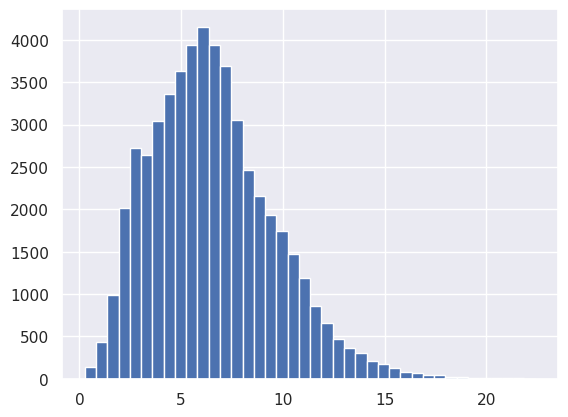

In [9]:
fig, ax = plt.subplots()

d = ax.hist(wt["Wind speed"], bins=40)

In [10]:
wt_1m = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")]

ws = wt_1m["Wind speed"]

In [11]:
ws.isnull().sum() == 0, len(ws)

(True, 4176)

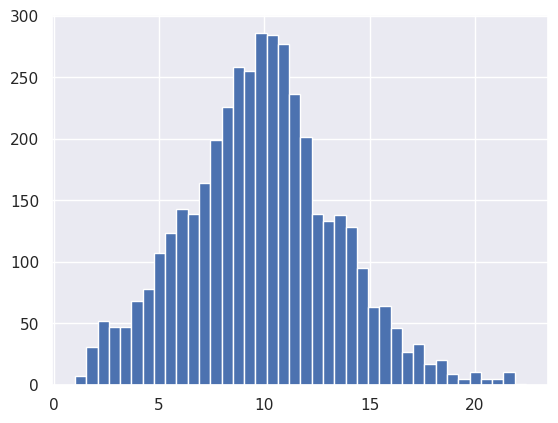

In [12]:
fig, ax = plt.subplots()

d = ax.hist(ws, bins=40)

## Modeling: Weibull

In [13]:
stan_file = f"{curr_dir}/../models/weibull.stan"

wb_stan = CmdStanModel(stan_file=stan_file)
input_data = {
    "N": len(ws),
    "y": ws.values
}
fit = wb_stan.sample(data=input_data)

12:12:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:24 - cmdstanpy - INFO - CmdStan done processing.
12:12:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: weibull_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/cam/workspace/projects/REStats/REStats/models/weibull.stan', line 12, column 2 to column 28)
	Exception: weibull_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/cam/workspace/projects/REStats/REStats/models/weibull.stan', line 12, column 2 to column 28)
	Exception: weibull_lpdf: Shape parameter is inf, but must be positive finite! (in '/home/cam/workspace/projects/REStats/REStats/models/weibull.stan', line 12, column 2 to column 28)
	Exception: weibull_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/cam/workspace/projects/REStats/REStats/models/weibull.stan', line 12, column 2 to column 28)
Exception: weibull_lpdf: Shape parameter is inf, but must be positive finite! (in '/home/cam/workspace/projects/REStats/REStats/models/weibull.stan'

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

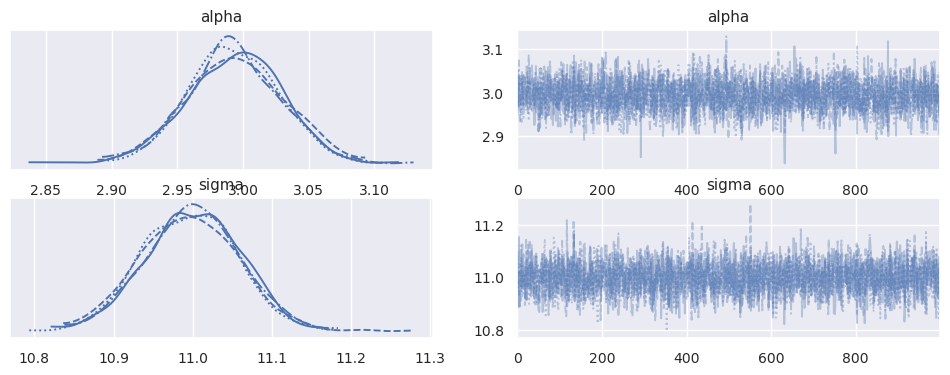

In [14]:
idata_wb = az.from_cmdstanpy(
    fit, 
    posterior_predictive="y_rep", 
    observed_data={"y": input_data["y"]}, 
    log_likelihood="log_lik"
)
az.plot_trace(idata_wb)

In [15]:
az.loo(idata_wb)

Computed from 4000 posterior samples and 4176 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11212.64    44.77
p_loo        2.23        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4176  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<Axes: xlabel='y / y_rep'>

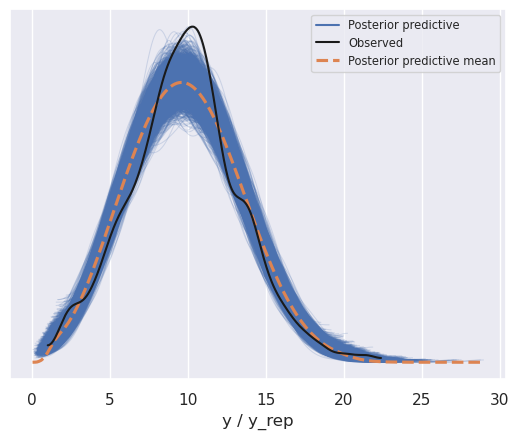

In [16]:
az.plot_ppc(idata_wb, data_pairs={"y": "y_rep"})

In [17]:
shape = idata_wb.posterior.alpha.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.sigma.mean(["chain", "draw"]).item(0)

m = shape / 3.6
v = ws**m

print(f"m: {m}")

m: 0.831450395138889


We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

/tmp/ipykernel_10567/877995192.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


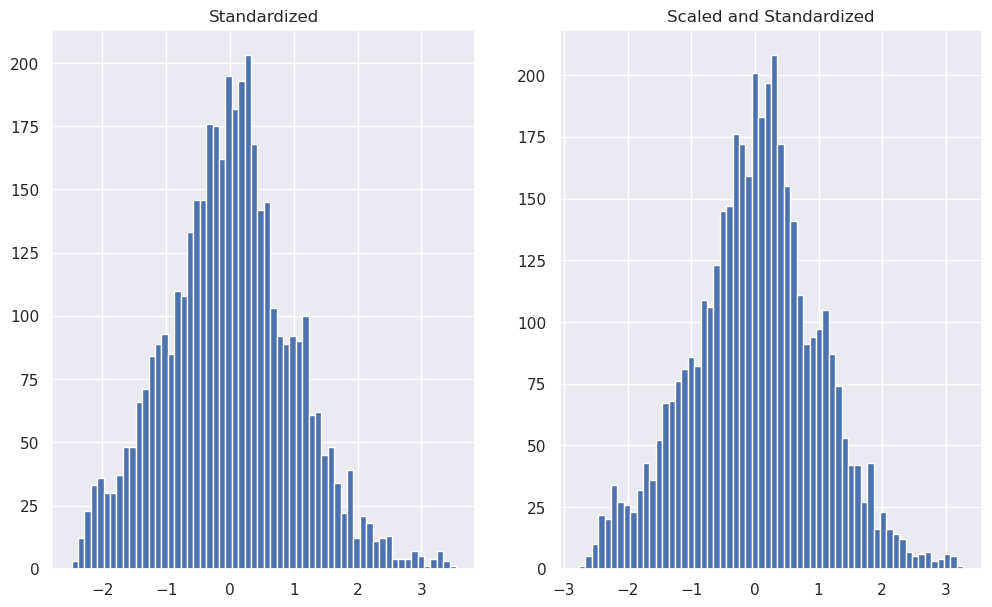

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].set_title("Standardized")
ax[0].hist(standardize(ws, ws), bins=60)

ax[1].set_title("Scaled and Standardized")
ax[1].hist(standardize(v, v), bins=60)

fig.show()

## Modeling: Stan

Autoregressive Moving Average (ARMA) model:

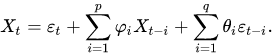

In [30]:
v_train_scaled = standardize(v, v)

In [31]:
curr_dir = os.getcwd()
stan_file = f"{curr_dir}/../models/wind_speed.stan"
stan_model = CmdStanModel(stan_file=stan_file)

12:15:22 - cmdstanpy - INFO - compiling stan file /home/cam/workspace/projects/REStats/REStats/models/wind_speed.stan to exe file /home/cam/workspace/projects/REStats/REStats/models/wind_speed
12:15:32 - cmdstanpy - INFO - compiled model executable: /home/cam/workspace/projects/REStats/REStats/models/wind_speed


In [32]:
input_data = {
    "T": len(v_train_scaled),
    "y": v_train_scaled.values
}
fit = stan_model.sample(data=input_data, chains=2)

12:15:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

12:17:09 - cmdstanpy - INFO - CmdStan done processing.
12:17:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/cam/workspace/projects/REStats/REStats/models/wind_speed.stan', line 27, column 2 to column 25)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/cam/workspace/projects/REStats/REStats/models/wind_speed.stan', line 27, column 2 to column 25)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/cam/workspace/projects/REStats/REStats/models/wind_speed.stan', line 27, column 2 to column 25)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/cam/workspace/projects/REStats/REStats/models/wind_speed.stan', line 27, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


In [33]:
idata_ws = az.from_cmdstanpy(
    fit, 
    posterior_predictive=["y_rep"],
    observed_data={"y": input_data["y"]},
    log_likelihood="log_lik"
)

In [34]:
idata_ws

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [88]:
az.summary(idata_ws, var_names=["phi", "theta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],1.559,0.046,1.474,1.647,0.002,0.001,521.0,582.0,1.0
phi[1],-0.564,0.045,-0.650,-0.481,0.002,0.001,521.0,600.0,1.0
theta,-0.745,0.038,-0.813,-0.672,0.002,0.001,545.0,596.0,1.0
sigma,0.250,0.003,0.245,0.255,0.000,0.000,833.0,664.0,1.0


In [35]:
az.loo(idata_ws) # -135.95    66.47

Computed from 2000 posterior samples and 4176 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -136.02    66.50
p_loo        6.45        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4176  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

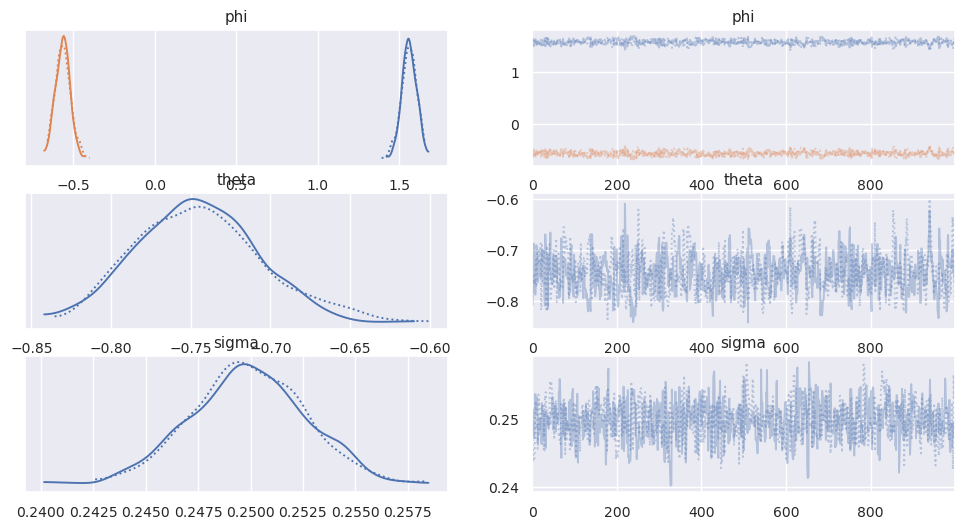

In [36]:
az.plot_trace(idata_ws, var_names=["~err", "~nu"])

<Axes: xlabel='y / y_rep'>

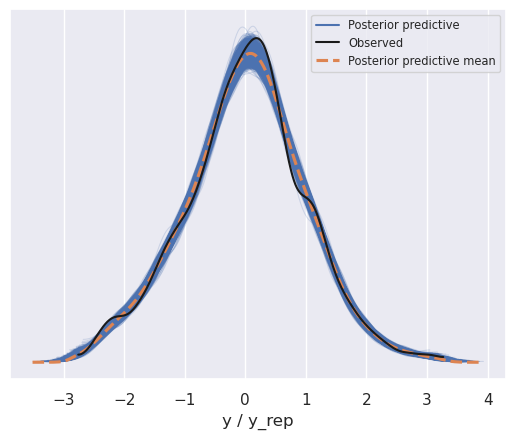

In [37]:
az.plot_ppc(idata_ws, data_pairs={"y": "y_rep"})

In [38]:
idata_ws

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

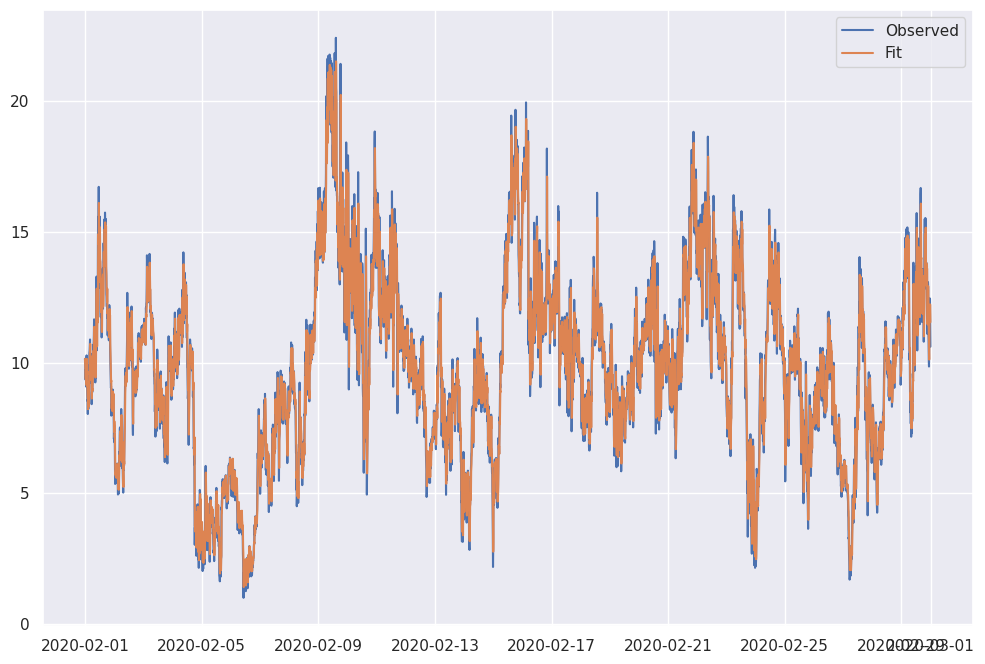

In [89]:
fig, ax = plt.subplots(figsize=(12, 8))

ws_ppc_mean = idata_ws.posterior_predictive.y_rep.mean(["chain", "draw"])
ws_pred = inverse_transform(ws_ppc_mean, v)**(1/m)

ax.plot(ws.index, ws, label="Observed")
ax.plot(ws.index, ws_pred, label="Fit")
ax.legend()

In [40]:
rmse_arma = mean_squared_error(ws, ws_pred, squared=False)
rmse_arma

0.9090168483976478

In [41]:
ws_per = ws.shift(1)
ws_per = ws_per.bfill()
rmse_per = mean_squared_error(ws, ws_per, squared=False)

In [42]:
rmse_arma - rmse_per # -0.027358072937032962

-0.027523647116913907

## Forecasting

In [43]:
pred_file = f"{curr_dir}/../models/wind_speed_pred.stan"
model_pred = CmdStanModel(stan_file=pred_file)

In [44]:
pred_data = input_data = {
    "T": len(v_train_scaled),
    "y": v_train_scaled.values,
    "n_pred": 6 # steps ahead to predict
}

new_quantities = model_pred.generate_quantities(data=pred_data, previous_fit=fit)

12:17:34 - cmdstanpy - INFO - Chain [1] start processing
12:17:53 - cmdstanpy - INFO - Chain [1] done processing
12:17:53 - cmdstanpy - INFO - Chain [2] start processing
12:18:13 - cmdstanpy - INFO - Chain [2] done processing


In [45]:
new_quantities

CmdStanGQ: model=wind_speed_pred chains=2['method=generate_quantities', 'fitted_params=/tmp/tmp97cagdhc/wind_speed82rcqihs/wind_speed-20230306121532_1.csv']
 csv_files:
	/tmp/tmp97cagdhc/wind_speed_pred938au4a_/wind_speed_pred-20230306121734_1.csv
	/tmp/tmp97cagdhc/wind_speed_pred938au4a_/wind_speed_pred-20230306121734_2.csv
 output_files:
	/tmp/tmp97cagdhc/wind_speed_pred938au4a_/wind_speed_pred-20230306121734_0-stdout.txt
	/tmp/tmp97cagdhc/wind_speed_pred938au4a_/wind_speed_pred-20230306121734_1-stdout.txt

In [46]:
idata_ws_fut = az.from_cmdstanpy(new_quantities)

12:18:21 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
12:18:21 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".


In [49]:
wt_plus = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01 01:00:00")]
ws_plus = wt_plus["Wind speed"]

ws_fut_mean = idata_ws_fut.posterior.predict.mean(["chain", "draw"])
ws_fut = inverse_transform(ws_fut_mean, v)**(1/m)

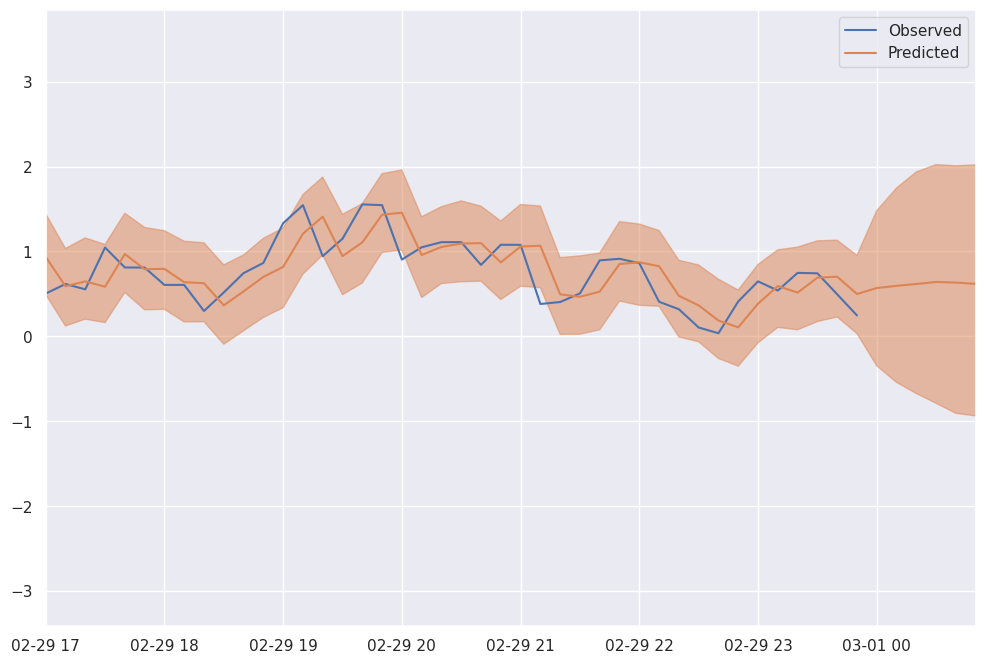

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ws.index, v_train_scaled, label="Observed")
ax.plot(ws_plus.index, ws_fut_mean, label="Predicted")
az.plot_hdi(ws_plus.index, idata_ws_fut.posterior.predict, smooth=False, ax=ax)

ax.set_xlim([ws_plus.index[-(6*8)], ws_plus.index[-1]])
ax.legend()

## Sanity Check: `statsmodels`

In [83]:
from statsmodels.tsa.arima.model import ARIMA

arma_mod = ARIMA(input_data["y"], order=(2, 0, 1), trend="n")
arma_res = arma_mod.fit()

In [85]:
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4176
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -132.273
Date:                Mon, 06 Mar 2023   AIC                            272.546
Time:                        12:38:49   BIC                            297.895
Sample:                             0   HQIC                           281.512
                               - 4176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5757      0.034     45.936      0.000       1.508       1.643
ar.L2         -0.5804      0.034    -17.271      0.000      -0.646      -0.515
ma.L1         -0.7600      0.030    -25.556      0.0

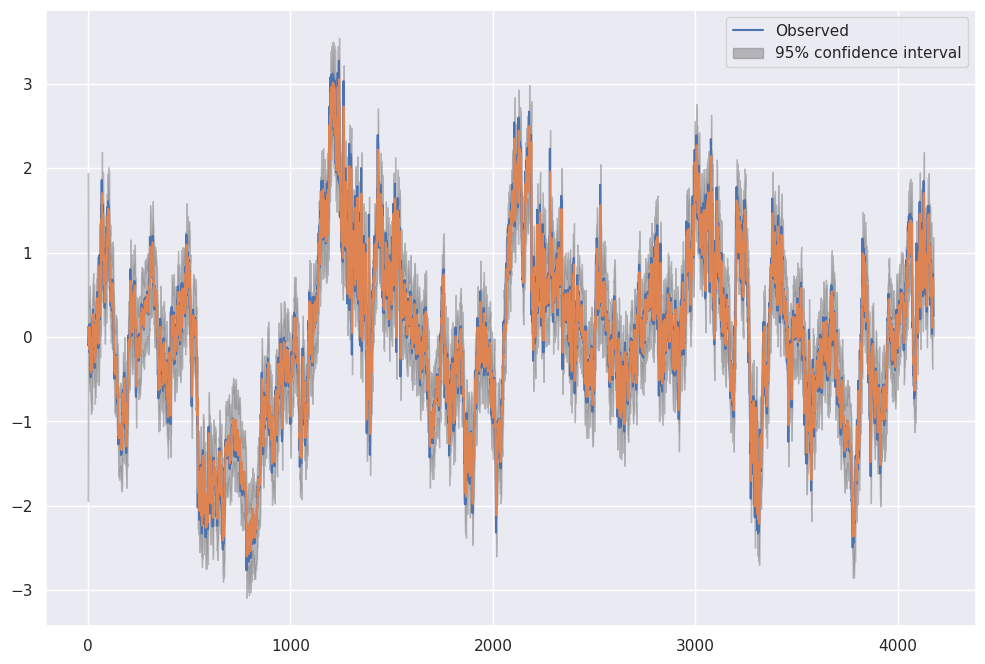

In [86]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tools.eval_measures import rmse

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(range(len(ws.index)), v_train_scaled, label="Observed")
plot_predict(arma_res, ax=ax)

ax.legend()

In [87]:
arma_pred = inverse_transform(arma_res.get_prediction().predicted_mean, v)**(1/m)

mean_squared_error(arma_pred, ws)

0.8266582858308021